# Hybrid Pumping Cell Characterization

This document is meant for conducting cell characterization measurements for the hybrid pumping set up.

This document will 
1. Characterize the absorption sprectra and measure the potassium density. The steps of this experiment include: heating up the cell, using the potassium laser aligned with the cell to a receiving powerimeter, sweeping the temperature of the probe to alter the frequency of the laser and use that to sweep across resonance. See git to see more elaborate methodology

# Import statements and Initialization

In [ ]:
#import statements
import numpy as np
import matplotlib.pyplot as plt
import one_ring.base.fitting_tools as fitt
import one_ring.daq.nidaqmx_tools as ndaq
import one_ring.base.signal_tools as sit
import one_ring.base.pandas_tools as pdt
import importlib
from one_ring.base.pint_units import ureg
import one_ring.base.h5py_tools as h5t
import scipy.constants
%matplotlib widget
import time as tm
import one_ring.daq.visa_instruments as nvisa
plt.style.use("dark_background")
import pandas as pd
from importlib import reload

#import nidaqmx as ni
import pyvisa as visa
import one_ring.daq.thorlabs as thor
import one_ring.daq.stanford_research_systems as srs
file_name = "../data/absorption_measurements.h5"

In [ ]:
#useful constants
#HH_Calib = 0.2*ureg.uT/(1*ureg.mA) #helmholtz coils
#fluxgate_Calib = 100*ureg.uT/(10*ureg.V) #fluxgate 
#outfname = "../data/hybrid_pumping.h5"
#rad_e = scipy.constants.physical_constants['classical electron radius'][0] * ureg.m
#c = scipy.constants.c*ureg.m/ureg.s
#f_D1 = 1/3 #oscillator strength of d1 transition

#{'slope': -0.02994121176448456, 'intercept': 389.74896028618315}

#from previous measurements
#freq_per_temp = -0.02994121176448456 * ureg.THz / ureg.delta_degC
#freq_per_temp_b = 389.74896028618315 * ureg.THz

In [3]:
srs.SRS860LockIn.list_resources()

('USB0::0x1313::0x8078::P0049964::INSTR',
 'USB0::0x1313::0x8078::P0009545::INSTR',
 'ASRL1::INSTR',
 'ASRL4::INSTR')

In [4]:
laser = srs.LDC501LaserController('ASRL4::INSTR')
laser.identity

'Stanford_Research_Systems,LDC501,s/n148698,ver2.46\r'

In [5]:
fs = 10 * ureg.Hz
dur = 2 * ureg.s
fm = ndaq.FiniteMeasurement(dur.m, (fs * dur).m, num_channels=1)

In [ ]:
#laser.close()

### Initializing one powermeter

In [8]:
pm = thor.PM100DPowerMeter('USB0::0x1313::0x8078::P0049964::INSTR')
pm.wavelength = 770

In [9]:
def measure_one_power():
    return pm.get_power().to(ureg.mW)

### Initializing two powermeters

In [ ]:
pm_hot = thor.PM100DPowerMeter('USB0::0x1313::0x8078::P0049964::INSTR')
pm_ref = thor.PM100DPowerMeter('USB0::0x1313::0x8078::P0021883::INSTR')

pm_hot.num_average = 1000 #one second average
pm_ref.num_average = 1000

In [ ]:
select_wavelength = 770
pm_ref.wavelength = select_wavelength
pm_hot.wavelength = select_wavelength

In [ ]:
pm_ref.wavelength

In [ ]:
def measure_two_powers():
    hot = pm_hot.get_power().to(ureg.uW)
    ref = pm_ref.get_power().to(ureg.uW)
    return (hot,ref)

def measure_one_power():
    return pm_hot.get_power().to(ureg.uW)

In [ ]:
pm_hot.get_power().to(ureg.uW)

# Heating up the cell

### Heating up with DAQ

the function generator is outputing a sinewave at amplitude 11.1Vpp at 10 kHz. This is fed into the multiplier chip with a control signal coming from the PID temperature controller and and it sends the multiplied. Make sure to keep a careful watch on the amplitude with the oscilloscope and the frequency of the analogue output. The Vpp amplitude is about 79.6Vpp. I have 11 resistors in parallel that make about 8.6 ohm of resistance.

if using DAQ i use AO 6.54 V amplitude at 1 kHz

In [ ]:
f = 1000 * ureg.Hz
fs = 128 * f
samples_per_call = 5*fs.to(ureg.Hz).m
amp = 6.6 * ureg.V

sine_waveform = sit.SineGenerator(fs, amp.to(ureg.V).m, f, 0)

In [ ]:
ao_task = ndaq.AnalogOutputTask(fs, "CONTINUOUS")

In [ ]:
ao_task.configure_channels(1)

In [ ]:
ao_task.configure_finite_generation(next(sine_waveform))

In [ ]:
ao_task.start()

In [ ]:
ao_task.stop()

In [ ]:
ao_task.close()

### Heating up with Function Generator

this involves setting function generator to 10.2VPP at 10kHz

# DAQ Monitoring

In [ ]:
fs = 10 * ureg.Hz
dt = 1/fs
DAQViewer = ndaq.DAQViewer(dt)

In [ ]:
DAQViewer.configure_channels()

In [ ]:
DAQViewer.display()

# Data Acquisition: K-Laser scan with Digital PMD100s

In [42]:
#specify your scanning range
min_temp = ureg.Quantity(14, ureg.degC)
max_temp = ureg.Quantity(18, ureg.degC)

I_saturation = 1.7 * ureg.mW/ureg.cm**2
probe_power = 0.319*ureg.mW
power_density = (2 * probe_power / ((2*ureg.cm/2)**2 * np.pi)).to(ureg.mW/ureg.cm**2)
(power_density)

<Quantity(0.203081707, 'milliwatt / centimeter ** 2')>

### acquire one power meter data 

In [44]:
#digital acquisition for one powermeter
temp_arr, out_queue_dig = laser.scan_temp_and_measure(measure_one_power, max_temp, 0.03/4*ureg.delta_degC,
                            initial_temp=min_temp,initial_settle_time=5*ureg.s,
                                                 settle_time=2*ureg.s);

0it [00:00, ?it/s]

In [45]:
results_dig = out_queue_dig.get_nowait() 

In [46]:
Power_arr = fm.unpack_averaged_measurements(results_dig)

### acquire two power meters and wavemeter data 

In [ ]:
min_temp = ureg.Quantity(14, ureg.degC)
max_temp = ureg.Quantity(18, ureg.degC)
step_size = 0.02 * ureg.delta_degC
num_steps = ( max_temp - min_temp ) / step_size
print(num_steps,(num_steps * 2 * ureg.s).to(ureg.min))

In [ ]:
#digital acquisition for one powermeter
fscan_dig, out_queue_dig = laser.scan_temp_and_measure(measure_powers_and_frequency, max_temp, 0.02*ureg.delta_degC,
                            initial_temp=min_temp,initial_settle_time=30*ureg.s,
                                                 settle_time=2*ureg.s);

In [ ]:
results_dig= out_queue_dig.get_nowait() 

In [ ]:
a,b,c,d  = zip(*results_dig)
P_hot = np.array([])
P_ref = np.array([])
freq = np.array([])
P_wlm = np.array([])
for i,m in enumerate(a):
    P_hot = np.vstack(a) 
    P_ref = np.vstack(b) 
    freq = np.vstack(c) 
    P_wlm = np.vstack(d) 
P_hot = P_hot.flatten()
P_ref = P_ref.flatten()
freq = freq.flatten()
P_wlm = P_wlm.flatten()

### acquire two power meter data

In [ ]:
#digital acquisition for two powermeters
fscan_dig, out_queue_dig = laser.scan_temp_and_measure(measure_two_powers, max_temp, 0.04*ureg.delta_degC,
                            initial_temp=min_temp,initial_settle_time=5*ureg.s,
                                                 settle_time=0.2*ureg.s);

In [ ]:
results_dig = out_queue_dig.get_nowait() 

In [ ]:
P_hot, P_ref = fm.unpack_averaged_measurements(results_dig)

### Absorption Powernormalizing Tools

In [ ]:
import scipy.optimize as optimize

def transmission_err(params):
    full_transmission = np.zeros(fscan_dig.m.size) + 1
    x_trans ,y_factor = params
    transformed_P_ref = P_ref.m * y_factor + x_trans
    normalized_transmission = transformed_P_ref/P_hot.m 
    error = np.sum((full_transmission - normalized_transmission)**2)
    return error

In [ ]:
initial_guess = [-19, 14.936437549819297]
result = optimize.minimize(transmission_err,initial_guess)
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)

### Test visualizing 

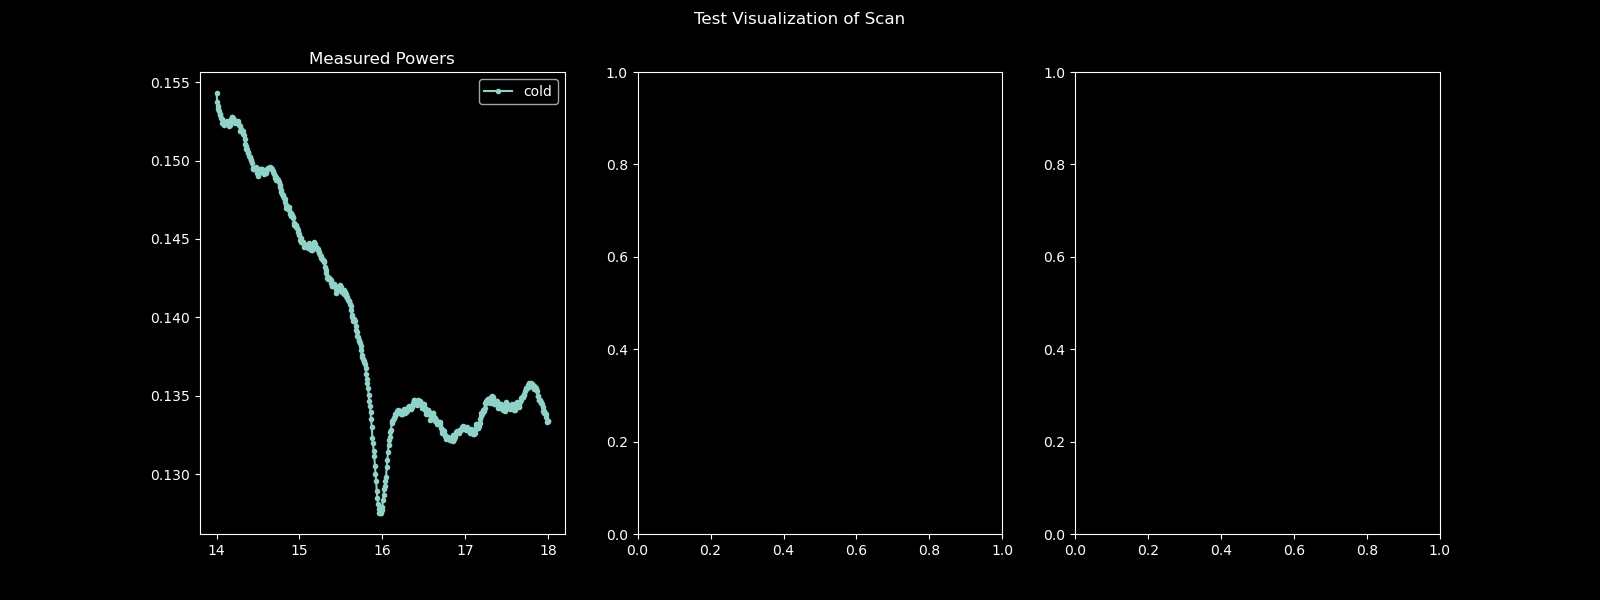

In [47]:
fig, axes = plt.subplots(figsize=(16,6),ncols=3)
ax = axes[0]
ax1 = axes[1]
ax2 = axes[2]

x_arr = temp_arr
y_arr = Power_arr
gain_normalizing = 1

ax.plot(x_arr.m, y_arr.m   ,marker='.',label='cold',color='C0')

plt.suptitle('Test Visualization of Scan')
ax.set_title('Measured Powers')
ax.legend()
plt.show()

### Save Data

In [48]:
outfname = file_name
grp_name = "wulgang_2025_11_21/scan2"
#grp_name = "elsa_2025_07_11/absorption"
h5t.save_dataset(outfname, grp_name, "temperature", temp_arr)
h5t.save_dataset(outfname, grp_name, "power", Power_arr)
metadata = {"probe_laser_current": 55*ureg.mA,
            "power_meter_head": "S121C",
            "probe_power": 0.319*ureg.mW,
            "power_in/power_out": 0.319 / 0.136,
            "beam sampler ratio": 0,
            "pump_laser_current": 0*ureg.mA,
            "pump_temp": ureg.Quantity(0, ureg.degC),
            "power_meter_wavelength": pm.wavelength, #not 830
            "cell_temperature": ureg.Quantity(80, ureg.degC),
            "probe_1/e^2": 2*ureg.cm,
            "probe_power_density": power_density,
            "misc_notes": "scan done at 80degC. Same as scan1 but with x4 points. Expanded beam for low power density"}
h5t.update_node_metadata(outfname, metadata, grp_name)